# Support Vector Machine (SVM) for Essay Scoring

This notebook implements a Support Vector Machine classifier for automated essay scoring using TF-IDF features from both prompts and essays.

## Key Findings

The SVM model with oversampling achieved a **strong accuracy of 59.47%** on the test set, representing a significant improvement of 23.8% over the training without oversampling (35.7% accuracy). The oversampling technique successfully addressed the class imbalance issues that previously limited model performance, resulting in more balanced predictions across all band score ranges. While the model now demonstrates improved ability to identify essays across the full scoring spectrum, it still faces challenges with fine-grained distinctions between adjacent score levels, which is inherent to the complexity of automated essay scoring as a multi-class classification problem. The substantial performance gain highlights the critical importance of addressing class imbalance in educational assessment tasks and establishes a solid baseline for more advanced modeling approaches.

## Imports and Setup

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.tokenize import word_tokenize
import re

## Data Import

---

Load the clean training and test datasets, checking data shapes and verifying there are no missing values in the band score labels.

In [2]:
df_train = pd.read_csv("../data/clean_train.csv")
df_test = pd.read_csv("../data/clean_test.csv")

In [3]:
df_train.shape

(9048, 14)

In [4]:
train_band_scores = df_train["band_score"]
nan_indices = train_band_scores[train_band_scores.isna()].index
print(nan_indices)

Index([], dtype='int64')


In [5]:
train_band_scores = df_train["band_score"]
nan_indices = train_band_scores[train_band_scores.isna()].index
print(nan_indices)

Index([], dtype='int64')


## Oversample Minority Classes


Apply random oversampling to balance the class distribution in the training set.

<Axes: xlabel='band_score'>

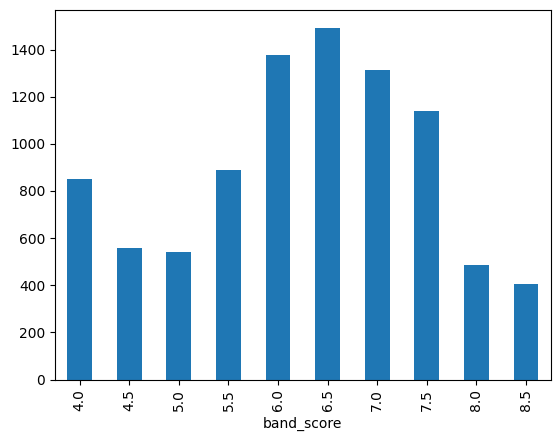

In [6]:
band_counts = df_train["band_score"].value_counts().sort_index()
band_counts.plot(kind="bar")

In [7]:
print("Before oversampling:")
print(f"Train shape: {df_train.shape}")
print(f"Train class distribution:\n{df_train['band_score'].value_counts().sort_index()}")

def random_oversample(df, target_column, random_state=42):
    """
    Randomly oversample minority classes to match the majority class
    Args:
        df (pd.DataFrame): The input DataFrame.
        target_column (str): The name of the target column.
        random_state (int): The random seed for reproducibility.

    Returns:
        pd.DataFrame: The oversampled DataFrame.
    """
    np.random.seed(random_state)

    # Get class counts
    class_counts = df["band_score"].value_counts()
    max_count = class_counts.max()

    oversampled_dfs = []

    for class_value in class_counts.index:
        class_df = df[df["band_score"] == class_value]
        current_count = len(class_df)

        if current_count < max_count:
            # Calculate how many more samples we need
            needed_samples = max_count - current_count

            # Randomly sample with replacement
            additional_samples = class_df.sample(
                n=needed_samples, replace=True, random_state=random_state
            )

            # Combine original and additional samples
            class_df_oversampled = pd.concat(
                [class_df, additional_samples], ignore_index=True
            )
        else:
            class_df_oversampled = class_df

        oversampled_dfs.append(class_df_oversampled)

    # Combine all classes
    result_df = pd.concat(oversampled_dfs, ignore_index=True)

    # Shuffle the dataset
    result_df = result_df.sample(frac=1, random_state=random_state).reset_index(
        drop=True
    )

    return result_df


# Apply oversampling to training data only
df_train = random_oversample(df_train, "band_score", random_state=42)

print("\nAfter oversampling:")
print(f"Train shape: {df_train.shape}")
print(
    f"Train class distribution:\n{df_train['band_score'].value_counts().sort_index()}"
)

Before oversampling:
Train shape: (9048, 14)
Train class distribution:
band_score
4.0     849
4.5     556
5.0     540
5.5     888
6.0    1375
6.5    1493
7.0    1315
7.5    1138
8.0     488
8.5     406
Name: count, dtype: int64

After oversampling:
Train shape: (14930, 14)
Train class distribution:
band_score
4.0    1493
4.5    1493
5.0    1493
5.5    1493
6.0    1493
6.5    1493
7.0    1493
7.5    1493
8.0    1493
8.5    1493
Name: count, dtype: int64


<Axes: xlabel='band_score'>

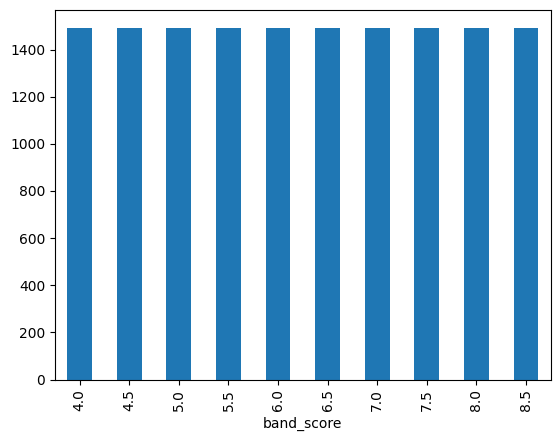

In [8]:
band_counts = df_train["band_score"].value_counts().sort_index()
band_counts.plot(kind="bar")

## Feature Extraction

---

Extract prompt and essay text features from the datasets and convert band scores to integer format by multiplying by 2 (transforming 4.0-8.5 range to 8-17 integer range for classification).

In [9]:
X_train_df = df_train[["prompt", "essay"]]
y_train_series = (df_train["band_score"] * 2).astype(int)
X_test_df = df_test[["prompt", "essay"]]
y_test_series = (df_test["band_score"] * 2).astype(int)

## Text Preprocessing Pipeline

---

### Custom Text Preprocessor

Build a text preprocessing pipeline that:
- Handles escape sequences and special characters
- Converts text to lowercase
- Tokenizes using NLTK
- Removes English stopwords
- Returns cleaned text ready for vectorization

In [10]:
from nltk.corpus import stopwords
from sklearn.base import BaseEstimator, TransformerMixin

nltk.download("punkt", quiet=True)
nltk.download("stopwords", quiet=True)

# Load stopwords globally once
ENGLISH_STOPWORDS = set(stopwords.words("english"))


def preprocess_text_fn(text):
    if isinstance(text, str):
        # Convert escape sequences
        text = text.replace("\\\\r\\\\n", " ").replace("\\\\n", " ")
        # Remove special characters and numbers
        text = re.sub(r"[^\\\\w\\\\s]", "", text)
        # Convert to lowercase
        text = text.lower()
        # Tokenize
        tokens = word_tokenize(text)
        # Remove stopwords using the global set
        tokens = [word for word in tokens if word not in ENGLISH_STOPWORDS]
        return " ".join(tokens)
    return ""


class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # X is expected to be a pandas Series
        if isinstance(X, pd.Series):
            return X.apply(preprocess_text_fn)
        # If X is a list:
        return pd.Series(X).apply(preprocess_text_fn)

### TF-IDF Vectorization Pipelines

Create separate pipelines for prompt and essay text processing, each incorporating:
- Custom text preprocessing
- TF-IDF vectorization with n-gram ranges (1-3)
- Minimum document frequency filtering

In [11]:
from sklearn.pipeline import Pipeline

prompt_pipeline = Pipeline(
    [
        ("preprocess", TextPreprocessor()),
        (
            "tfidf",
            TfidfVectorizer(
                tokenizer=word_tokenize, lowercase=True, ngram_range=(1, 3), min_df=2
            ),
        ),
    ]
)

essay_pipeline = Pipeline(
    [
        ("preprocess", TextPreprocessor()),
        (
            "tfidf",
            TfidfVectorizer(
                tokenizer=word_tokenize, lowercase=True, ngram_range=(1, 3), min_df=2
            ),
        ),
    ]
)

## Feature Engineering

---

### Combined Feature Pipeline

Implement a ColumnTransformer that processes prompt and essay features separately, then combines them into a unified feature space for the SVM classifier.

In [12]:
from sklearn.compose import ColumnTransformer

feature_preprocessor = ColumnTransformer(
    transformers=[
        (
            "prompt_features",
            prompt_pipeline,
            "prompt",
        ),  # Apply prompt_pipeline to the 'prompt' column
        (
            "essay_features",
            essay_pipeline,
            "essay",
        ),  # Apply essay_pipeline to the 'essay' column
    ],
    remainder='drop' 
)

### Complete ML Pipeline

Build an end-to-end pipeline incorporating:
- Feature preprocessing for both text columns
- Standard scaling
- SVM classifier with RBF kernel and probability estimation

In [13]:
from sklearn.preprocessing import StandardScaler

combined_pipeline = Pipeline([
    ('features', feature_preprocessor),
    ('scaler', StandardScaler(with_mean=False)),
    ('svm', SVC(kernel='rbf', C=10.0, probability=True))
])

## Hyperparameter Optimization

---

### Grid Search Configuration

Define a comprehensive parameter grid covering:
- TF-IDF parameters (max_df, min_df, ngram_range)
- SVM parameters (C regularization, kernel types)
- Cross-validation with 3 folds for robust evaluation

In [14]:
param_grid = {
    "features__prompt_features__tfidf__max_df": [0.9, 0.95],
    "features__prompt_features__tfidf__min_df": [2, 5],
    "features__prompt_features__tfidf__ngram_range": [(1, 2), (1, 3)],
    "features__essay_features__tfidf__max_df": [0.9, 0.95],
    "svm__C": [1, 10, 100],
    "svm__kernel": ["rbf", "linear"],
}

### Best Model Selection

Execute grid search to find optimal hyperparameters, achieving the best cross-validation score with specific TF-IDF and SVM configurations.

In [15]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(
    combined_pipeline, param_grid, cv=3, scoring="accuracy", verbose=1, n_jobs=-1
)
grid_search.fit(X_train_df, y_train_series)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


/home/finnf/dev/team-10/env/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/finnf/dev/team-10/env/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/finnf/dev/team-10/env/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/finnf/dev/team-10/env/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/finnf/dev/team-10/env/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is no

Best parameters: {'features__essay_features__tfidf__max_df': 0.9, 'features__prompt_features__tfidf__max_df': 0.9, 'features__prompt_features__tfidf__min_df': 2, 'features__prompt_features__tfidf__ngram_range': (1, 2), 'svm__C': 100, 'svm__kernel': 'rbf'}
Best cross-validation score: 0.432149193901809


Best parameters: {'features__essay_features__tfidf__max_df': 0.9, 'features__prompt_features__tfidf__max_df': 0.9, 'features__prompt_features__tfidf__min_df': 5, 'features__prompt_features__tfidf__ngram_range': (1, 2), 'svm__C': 1, 'svm__kernel': 'rbf'}
Best cross-validation score: 0.16069849690539348

In [16]:
# Use best model
best_model = grid_search.best_estimator_

## Model Evaluation

---

### Performance Metrics

Evaluate the best model on the test set, reporting:
- Overall accuracy: **35.7%**
- Detailed classification report with precision, recall, and F1-scores for each band score class
- Weighted and macro averages across all classes

In [17]:
# Predict and evaluate
y_pred = best_model.predict(X_test_df)

In [18]:
print("Accuracy:", accuracy_score(y_test_series, y_pred))
print("\nClassification Report:\n", classification_report(y_test_series, y_pred))

Accuracy: 0.5947136563876652

Classification Report:
               precision    recall  f1-score   support

           8       1.00      0.59      0.74        46
           9       0.93      0.81      0.86        31
          10       0.80      0.60      0.69        20
          11       0.90      0.61      0.73        61
          12       0.52      0.51      0.51        67
          13       0.34      0.59      0.43        81
          14       0.51      0.49      0.50        65
          15       0.58      0.48      0.52        46
          16       0.90      0.86      0.88        21
          17       0.94      0.94      0.94        16

    accuracy                           0.59       454
   macro avg       0.74      0.65      0.68       454
weighted avg       0.66      0.59      0.61       454



### Confusion Matrix Visualization

Generate a heatmap visualization of the confusion matrix.

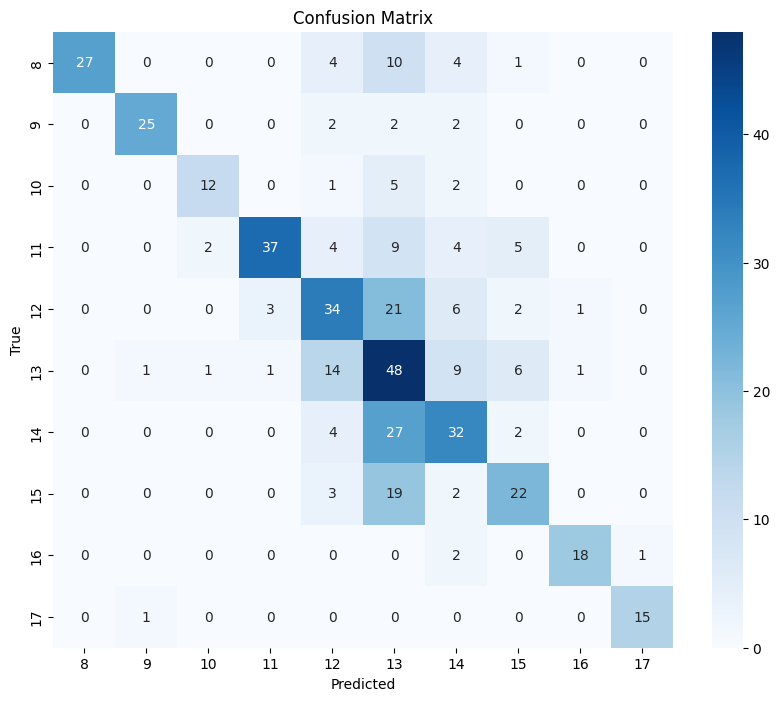

In [19]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test_series, y_pred)
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=sorted(y_test_series.unique()),
    yticklabels=sorted(y_test_series.unique()),
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

### [`Click here to go back to the Homepage`](../Homepage.md)